<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/ensemble_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import yfinance as yf
# import yahoo_fin.stock_info as si
# import mplfinance as mpf
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import random
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split,StratifiedKFold
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
import torch.cuda.amp as amp
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
loadPath ='/content/drive/MyDrive/myStocksSept2024/unitedData/'
savePath = '/content/drive/MyDrive/myStocksSept2024/savedModels/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Data is divided into 6 datasets, each containing all stocks and all date ranges, but with different offsets of dates.

Ensemble is generates such that 6 nets are constructed and trained on a different dataset. The test set is identical across trainings, and the final results is the sum of individual networks / majority vote. The networks are with classification outputs (either 6 or 8 labels) and cross entropy loss.

*   loading data
*   dividing target values into labels (either 6 or 8)
*   visualize target and label distributions
*   create a stratified training, validation and test loaders
*   create a 4 convolution layers, and 2 linear layers, with batch normalization and max pooling
*   optional weighted loss matrix for more extreme prediction errors
*   wieght decay and drop out rate for regularization
*   training error plot and confusion matrix are generated at end of training



In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def loadData(i,path):
  images = torch.load(path+f'images_tickers0-3315_[{str(i)}::6]_pool3_asHalf.pt')
  targetsDf = pd.read_pickle(path + f'targets_tickers0-3315_[{str(i)}::6]_pool3_asDf.pkl')
  targets = targetsDf.target.to_numpy()
  targets = torch.from_numpy(targets).half()
  print(images.shape)
  print(targets.shape)
  return images,targets


In [5]:
def generateLabelHistogram(labels,label_count, targets):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    bins = np.linspace(-1, 1, num=500)

    # Plot the histogram initially with lightgray and black edge colors
    hist1 = sns.histplot(targets.numpy(), bins=bins, color='lightgray', edgecolor='white', kde=False, ax=ax)
    counts, edges = np.histogram(targets.numpy(), bins=bins)

    # Define the low and high values for each label in sorted order
    lows = [torch.min(targets[labels == key]).item() for key, value in sorted(label_count.items())]
    highs = [torch.max(targets[labels == key]).item() for key, value in sorted(label_count.items())]

    # Set up the colormap with more divisions for values below -0.1
    cmap1 = plt.cm.get_cmap('coolwarm', 1000)  # Increase the number of color divisions for better resolution
    colors = [cmap1(i / (len(label_count) - 1)) for i in range(len(label_count))]

    # Create color_ranges with ranges for each color
    color_ranges = {}
    for i, (low, high) in enumerate(zip(lows, highs)):
        color_ranges[colors[i]] = (low, high)

    # Adjust color bins below -0.1 to have more granularity
    for i in range(len(counts)):

        # Determine the color for this bin based on the defined ranges
        bin_color = 'gray'  # Default color
        for color, (lower, upper) in color_ranges.items():
            if lower <= edges[i] < upper:
                hist1.patches[i].set_facecolor(color)

    # Create the label text with colored circles
    label_count_text = 'Label Frequency\n'
    for idx, (key, value) in enumerate(sorted(label_count.items())):
        color_circle = mpatches.Circle((0, 0), radius=0.1, color=colors[idx])  # Create a circle patch for each label color
        label_text = f'{key} : {round(value / np.sum(list(label_count.values())), 3)}'
        # Remove bbox frame by setting 'facecolor' to 'none' and omitting 'edgecolor'
        ax.text(0.95, 0.95 - (idx * 0.05), f'{label_text}', fontsize=7,
                ha='right', va='top', transform=ax.transAxes)
        ax.add_patch(mpatches.Circle((0.87, 0.94 - (idx * 0.05)), 0.01, color=colors[idx], transform=ax.transAxes, clip_on=False))

    ax.set_xlabel('Targets')
    ax.set_ylabel('Frequency')
    ax.set_xlim(-0.75, 0.75)
    ax.set_title(f'Target Distribution with {len(label_count)} Labels')
    plt.tight_layout()
    plt.show()

    return


In [6]:
  # For cross entropy with 6 labels
def labels6CE(targets,plot=True):
    labels = torch.zeros_like(targets).long()
    labels[targets >= 0.15] = 5
    labels[(targets < 0.15)&(targets>=0.075)] = 4
    labels[(targets < 0.075)&(targets>=0.0)] = 3
    labels[(targets < 0.0)&(targets>=-0.075)] = 2
    labels[(targets > -0.15)&(targets<=-0.075)] = 1
    label_count = Counter(labels.tolist())
    print(f'Labels and respective absolute counts in dataset:\n{label_count}')
    print('Labels and respective relative ratios:')
    print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
    classWeights = [round(1/(value / np.sum(list(label_count.values()))),2) for key, value in sorted(label_count.items())]
    print(f'Class Weights:\n{classWeights}')
    if plot:
      generateLabelHistogram(labels,label_count,targets)
    return labels,classWeights

In [7]:
  # For cross entropy with 8 labels
def labels8CE(targets,plot=True):
    labels = torch.zeros_like(targets).long()
    labels[targets >= 0.15] = 7
    labels[(targets < 0.15)&(targets>=0.075)] = 6
    labels[(targets < 0.075)&(targets>=0.0375)] = 5
    labels[(targets >= 0.0)&(targets < 0.0375)] = 4
    labels[(targets < 0.0)&(targets >= -0.0375)] = 3
    labels[(targets >= -0.075)&(targets<-0.0375)] = 2
    labels[(targets >= -0.15)&(targets <-0.075)] = 1
    label_count = Counter(labels.tolist())
    print(label_count)
    print('Labels and respective relative ratios:')
    print(' | '.join([f'{key} : {round(value / np.sum(list(label_count.values())),3)}' for key, value in sorted(label_count.items())]))
    classWeights = [round(1/(value / np.sum(list(label_count.values()))),2) for key, value in sorted(label_count.items())]
    print(f'Class Weights:\n{classWeights}')
    if plot:
      generateLabelHistogram(labels,label_count,targets)
    return labels,classWeights

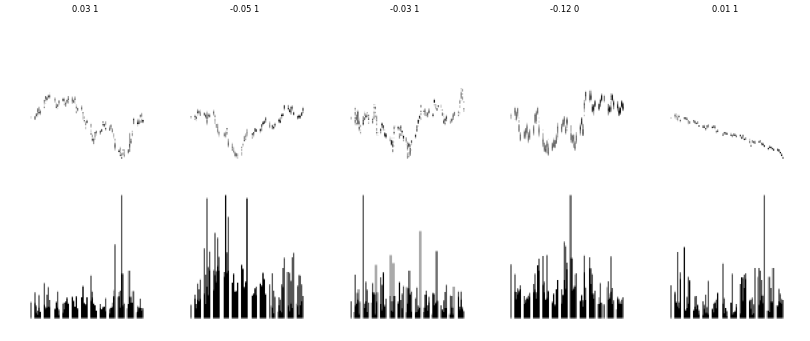

In [ ]:
# visualize some images
fig,axs = plt.subplots(2,5,figsize=(18,6),dpi=50)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(images.shape[0])

  # visualize
  axs[0,i].imshow(images[n,0,:,:],cmap='gray', aspect='auto')
  axs[1,i].imshow(images[n,1,:,:],cmap='gray', aspect='auto')
  axs[0,i].set_title(f'{round(targets[n].item(),2)} {labels[n].item()}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [9]:
def splitAndLoadData(images,labels, trainSplit = 0.15, testSplit=0.5):
  train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=trainSplit, stratify=labels)
  # del images
  val_data,test_data, val_labels,test_labels = train_test_split(test_data, test_labels, test_size=testSplit, stratify=test_labels)

  # PyTorch Datasets
  train_data = TensorDataset(train_data,train_labels)
  val_data = TensorDataset(val_data,val_labels)
  test_data  = TensorDataset(test_data,test_labels)

  # dataloader objects
  batchsize    = 64
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  val_loader   = DataLoader(val_data,batch_size=val_data.tensors[0].shape[0])
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
  return train_loader,val_loader,test_loader

In [19]:
def trainCEModel(numepochs,train_loader,val_loader,classWeights):
    print(f'{len(classWeights)} labels')
    # Create a new model
    CEnet, lossfun, optimizer = createCENet(classWeights,False)

    # Send the model to the GPU (do not convert to half)
    CEnet.to(device)
    # Do NOT use CEnet.half()

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # Initialize losses
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    valErr = torch.zeros(numepochs)
    batchLoss = []
    batchErr = []

    # Variable to store the best (lowest) validation accuracy and corresponding epoch
    bestValErr = float('inf')

    # Loop over epochs
    for epochi in range(numepochs):
        print(f'Epoch {epochi + 1}/{numepochs}')

        # Loop over training data batches
        CEnet.train()

        for X, y in train_loader:

            # Push data to GPU (do not convert to half)
            X = X.to(device)
            y = y.to(device).long()  # CrossEntropyLoss requires Long targets

            # Forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = CEnet(X)
                loss = lossfun(yHat, y)

            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"Warning: Loss is NaN or Inf: {loss.item()}")
                continue  # Skip this batch if loss is invalid

            # Backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(CEnet.parameters(), max_norm=1.0)

            # Step the optimizer
            scaler.step(optimizer)
            scaler.update()

            # Store loss
            batchLoss.append(loss.item())
            batchErr.append(100*torch.mean((torch.argmax(yHat, axis=1) != y).float()).item())

        # Store training loss and error
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = np.mean(batchErr)

        # Validation performance
        CEnet.eval()
        X, y = next(iter(val_loader))

        # Push data to GPU
        X = X.to(device)
        y = y.to(device).long()

        with torch.no_grad(), autocast():
            yHat = CEnet(X)
            loss = lossfun(yHat, y)

        # Store validation loss and error
        valLoss[epochi] = loss.item()
        valErr[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).item()

        # Check if the current validation error is the lowest
        if valErr[epochi] < bestValErr:
            bestValErr = valErr[epochi]
            bestModel = deepcopy(CEnet)
            # Save the model's state dict at the best epoch
            # torch.save(CEnet.state_dict(), savePath+f'CE_[1::2]_10labels_10epoch2nd_lowest_devError_learnRate003_111024.pt')
            print(f'Saving model at epoch {epochi + 1} with lowest dev error: {bestValErr:.2f}%')

    # Return losses and trained model
    return bestModel,trainLoss, valLoss, trainErr, valErr, batchLoss, batchErr,lossfun

In [26]:
def trainCEModelWeightedError(numepochs,train_loader,val_loader,classWeights,errorWeightMatrix,CEnet=None,lossfun=None, optimizer=None):
    print(f'{len(classWeights)} labels')
    # Create a new model
    if CEnet == None:
      CEnet, lossfun, optimizer = createCENet(classWeights,False)

    # Send the model to the GPU (do not convert to half)
    CEnet.to(device)
    # Do NOT use CEnet.half()

    # Initialize the scaler for AMP
    scaler = GradScaler()

    # Initialize losses
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainErr = torch.zeros(numepochs)
    valErr = torch.zeros(numepochs)
    batchLoss = []
    batchErr = []

    # Variable to store the best (lowest) validation accuracy and corresponding epoch
    bestValErr = float('inf')

    # Loop over epochs
    for epochi in range(numepochs):
        print(f'Epoch {epochi + 1}/{numepochs}')

        # Loop over training data batches
        CEnet.train()

        for X, y in train_loader:

            # Push data to GPU (do not convert to half)
            X = X.to(device)
            y = y.to(device).long()  # CrossEntropyLoss requires Long targets

            # Forward pass and loss with AMP
            with autocast():  # Enable mixed precision
                yHat = CEnet(X)
                baseLoss = lossfun(yHat, y)
                # Get predicted labels
                preds = torch.argmax(yHat, axis=1)
                # Calculate custom weighted loss
                customWeights = errorWeightMatrix[y, preds]  # Get the weight for each prediction mistake
                loss = baseLoss * customWeights.float().mean()  # Apply the custom weights to the loss

            # Check for NaN in loss
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f"Warning: Loss is NaN or Inf: {loss.item()}")
                continue  # Skip this batch if loss is invalid

            # Backprop with AMP
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(CEnet.parameters(), max_norm=1.0)

            # Step the optimizer
            scaler.step(optimizer)
            scaler.update()

            # Store loss
            batchLoss.append(loss.item())
            batchErr.append(100*torch.mean((torch.argmax(yHat, axis=1) != y).float()).item())

        # Store training loss and error
        trainLoss[epochi] = np.mean(batchLoss)
        trainErr[epochi] = np.mean(batchErr)

        # Validation performance
        CEnet.eval()
        X, y = next(iter(val_loader))

        # Push data to GPU
        X = X.to(device)
        y = y.to(device).long()

        with torch.no_grad(), autocast():
            yHat = CEnet(X)
            baseLoss = lossfun(yHat, y)
            preds = torch.argmax(yHat, axis=1)
            customWeights = errorWeightMatrix[y, preds]
            loss = baseLoss * customWeights.float().mean()  # Apply the custom weights to validation loss

        # Store validation loss and error
        valLoss[epochi] = loss.item()
        valErr[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).item()

        # Check if the current validation error is the lowest
        if valErr[epochi] < bestValErr:
            bestValErr = valErr[epochi]
            bestModel = deepcopy(CEnet)
            # Save the model's state dict at the best epoch
            # torch.save(CEnet.state_dict(), savePath+f'CE_[1::2]_10labels_10epoch2nd_lowest_devError_learnRate003_111024.pt')
            print(f'Saving model at epoch {epochi + 1} with lowest dev error: {bestValErr:.2f}%')

    # Return losses and trained model
    return bestModel,trainLoss, valLoss, trainErr, valErr, batchLoss, batchErr,lossfun, optimizer

In [12]:
# create a class for the model
def createCENet(classWeights,printtoggle=False):

  class stocknet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # Convolutional layers
      self.conv0 = nn.Conv2d(2, 16, 4, padding=1)
      self.bnorm0 = nn.BatchNorm2d(16)
      self.conv1 = nn.Conv2d(16, 32, 4, padding=1)
      self.bnorm1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 64, 4, padding=1)
      self.bnorm2 = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(64, 256, 4, padding=1)
      self.bnorm3 = nn.BatchNorm2d(256)
      self.conv4 = nn.Conv2d(256, 1024, 4, padding=1)
      self.bnorm4 = nn.BatchNorm2d(1024)

      # Linear layers
      self.fc1 = nn.Linear(4096, 256)
      self.fc2 = nn.Linear(256, 64)
      self.fc3 = nn.Linear(64, len(classWeights))

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # zero block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv0(x),2)
      x = F.leaky_relu(self.bnorm0(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # fourth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv4(x),2)
      x = F.leaky_relu(self.bnorm4(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      # x = F.dropout(x,p=.1,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stocknet(printtoggle)

  # loss function

  lossfun = nn.CrossEntropyLoss(weight=torch.tensor(classWeights, dtype=torch.half).to(device) )
  # lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.00025,weight_decay=0.00001)

  return net,lossfun,optimizer

In [13]:
def calcError(model,lossfun,loader):
  X,y = next(iter(loader))
  X = X.to(device).half()
  y = y.to(device).long()
  with torch.no_grad(), autocast():
      yHat = model(X)
      test_loss = lossfun(yHat, y)
  error = 100*torch.mean((torch.argmax(yHat.cpu(),axis=1) != y.cpu()).float()).item()
  return error,yHat,y

In [21]:
def plotTraining(trainLoss,devLoss,trainErr,valErr,batchLoss,batchErr,nEpochs):

  fig,ax = plt.subplots(1,2,figsize=(16,5))
  xaxispoints = np.linspace(0,len(batchLoss),nEpochs)
  ax[0].plot(xaxispoints,trainLoss,'s-',label='Train')
  ax[0].plot(xaxispoints,valLoss,'o-',label='Dev')
  ax[0].plot(batchLoss,'s',label='Batch',markersize=1,alpha=0.1)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss (CE)')
  # ax[0].set_title(f'{len(class_weights)} label loss')
  ax[0].set_ylim(0,torch.max(trainLoss)*1.1)
  ax[0].legend()

  ax[1].plot(xaxispoints,trainErr,'s-',label='Train')
  ax[1].plot(xaxispoints,valErr,'o-',label='Dev')
  ax[1].plot(batchErr,'s',label='Batch',markersize=1,alpha=0.1)
  ax[1].plot(len(batchLoss),testErr,'*',label='Test',markersize=15, color='r')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Error rates (%)')
  # ax[1].set_title(f'Final model dev error rate: {valErr[-1]:.2f}%')
  ax[1].legend()

  plt.show()
  return

In [22]:
def plotConfusion(yHat,y,classWeights):
  # compute the confusion matrix without normalization
  C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1))

  # Normalize per prediction (by columns)
  columnSums = C.sum(axis=0)  # Get the sum for each column
  C_normalized = C / columnSums[np.newaxis, :]  # Divide each element by its column sum

  # visualize it
  fig = plt.figure(figsize=(7,7))
  plt.imshow(C_normalized, cmap='cividis', vmax=.7)

  # make the plot look nicer
  plt.xticks(range(len(classWeights)))
  plt.yticks(range(len(classWeights)))
  plt.title('TEST Confusion Matrix (Normalized by Prediction)')
  plt.xlabel('Predicted Number')
  plt.ylabel('True Number')
  plt.colorbar()

  C = skm.confusion_matrix(y.cpu(), torch.argmax(yHat.cpu(), axis=1))
  # Add the values inside the squares
  for i in range(C.shape[0]):
      for j in range(C.shape[1]):
          plt.text(j, i, f'{int(C[i, j])}', ha='center', va='center', color='red')

  plt.show()
  return C

In [18]:
errorWeightMatrix = torch.tensor([[ 0 , 1 , 1 , 1 , 3 , 10, 20 ,20],
                                  [ 1 , 0 , 1 , 1 , 2 , 5, 10 ,10],
                                  [ 1 , 1 , 0 , 1 , 1 , 2 , 5 , 5],
                                  [ 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1],
                                  [ 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1],
                                  [ 5 , 5 , 2 , 1 , 1 , 0 , 1 , 1],
                                  [10 ,10 , 5 , 2 , 1 , 1 , 0 , 1],
                                  [20 ,20 , 10 , 3 , 1 , 1 , 1 , 0]]).to(device)


print(errorWeightMatrix)

tensor([[0, 1, 1, 1, 3, 4, 5, 5],
        [1, 0, 1, 1, 2, 3, 4, 4],
        [1, 1, 0, 1, 1, 2, 3, 3],
        [1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [3, 3, 2, 1, 1, 0, 1, 1],
        [4, 4, 3, 2, 1, 1, 0, 1],
        [5, 5, 4, 3, 1, 1, 1, 0]], device='cuda:0')


0
torch.Size([54804, 2, 120, 120])
torch.Size([54804])
Counter({4: 11304, 3: 10920, 2: 7070, 5: 7024, 1: 6501, 6: 5654, 0: 3293, 7: 3038})
Labels and respective relative ratios:
0 : 0.06 | 1 : 0.119 | 2 : 0.129 | 3 : 0.199 | 4 : 0.206 | 5 : 0.128 | 6 : 0.103 | 7 : 0.055
Class Weights:
[16.64, 8.43, 7.75, 5.02, 4.85, 7.8, 9.69, 18.04]


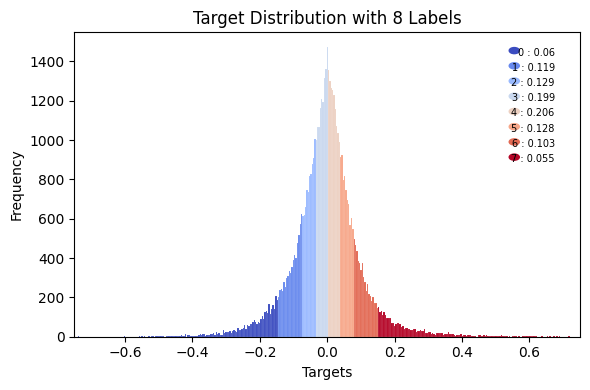

8 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 87.20%
Epoch 2/10
Epoch 3/10
Saving model at epoch 3 with lowest dev error: 78.64%
Epoch 4/10
Epoch 5/10
Epoch 6/10
Saving model at epoch 6 with lowest dev error: 77.59%
Epoch 7/10
Epoch 8/10
Saving model at epoch 8 with lowest dev error: 77.54%
Epoch 9/10
Epoch 10/10
Test Error : 77.91%


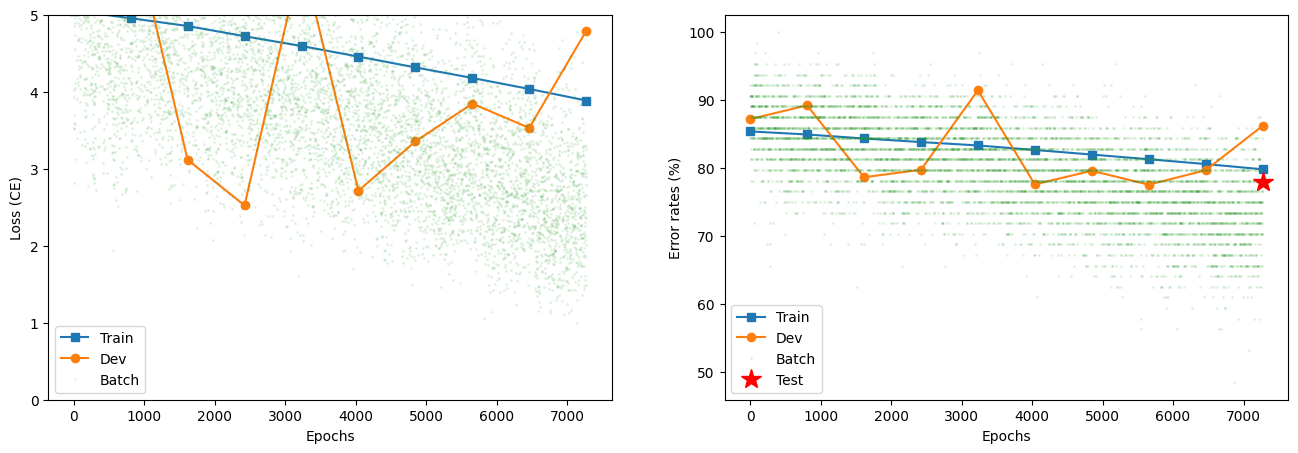

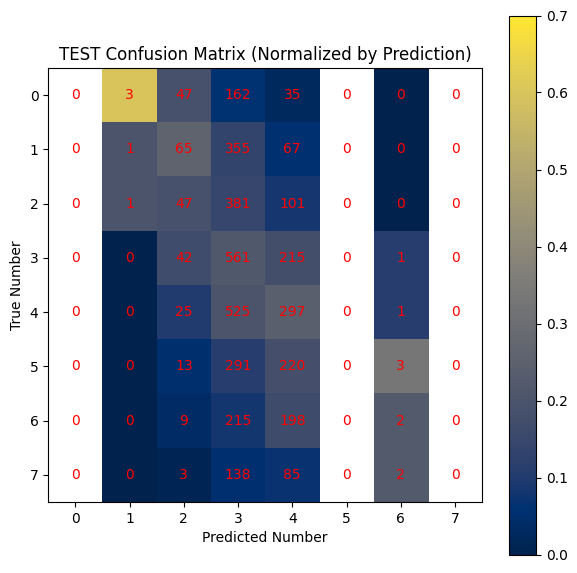

1
torch.Size([54804, 2, 120, 120])
torch.Size([54804])
Counter({4: 11289, 3: 11002, 2: 7217, 5: 6927, 1: 6473, 6: 5599, 0: 3284, 7: 3013})
Labels and respective relative ratios:
0 : 0.06 | 1 : 0.118 | 2 : 0.132 | 3 : 0.201 | 4 : 0.206 | 5 : 0.126 | 6 : 0.102 | 7 : 0.055
Class Weights:
[16.69, 8.47, 7.59, 4.98, 4.85, 7.91, 9.79, 18.19]
8 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 88.75%
Epoch 2/10
Saving model at epoch 2 with lowest dev error: 82.45%
Epoch 3/10
Epoch 4/10
Saving model at epoch 4 with lowest dev error: 80.03%
Epoch 5/10
Epoch 6/10
Saving model at epoch 6 with lowest dev error: 78.95%
Epoch 7/10
Epoch 8/10
Epoch 9/10
Saving model at epoch 9 with lowest dev error: 77.83%
Epoch 10/10
Test Error : 77.72%


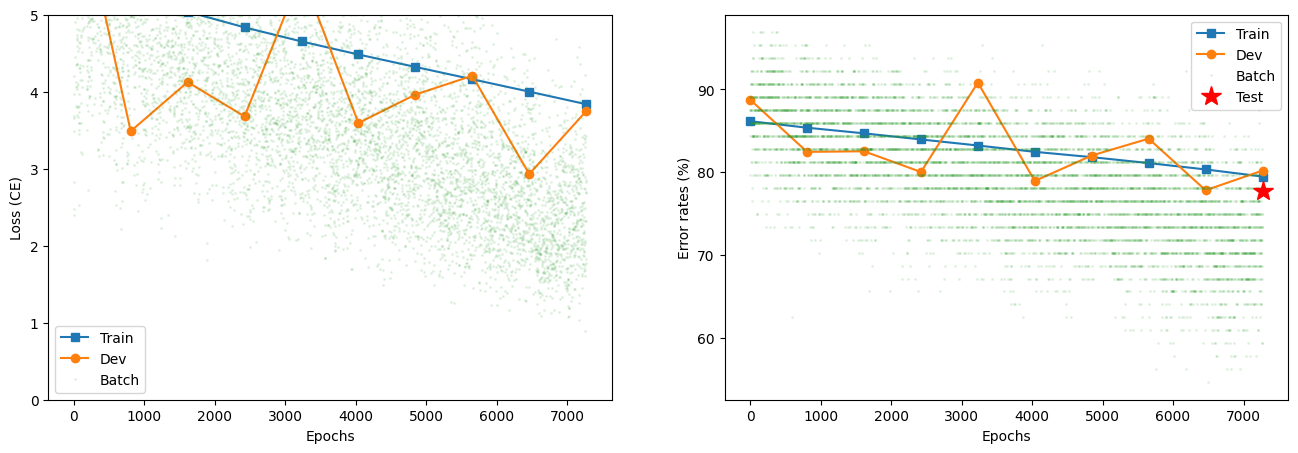

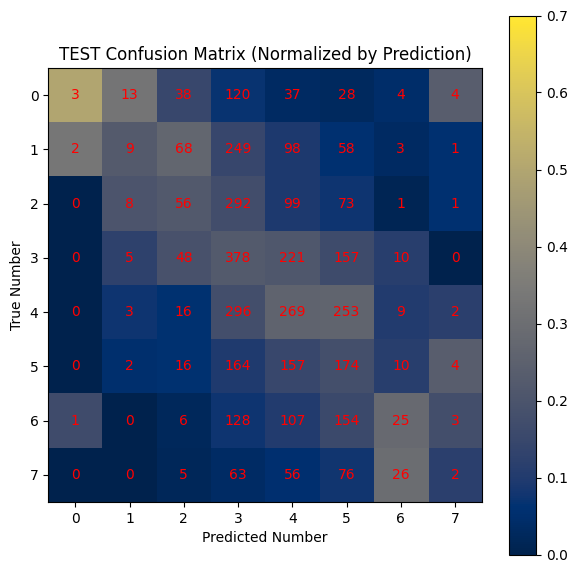

2
torch.Size([54802, 2, 120, 120])
torch.Size([54802])
Counter({4: 11105, 3: 11048, 2: 7313, 5: 6955, 1: 6415, 6: 5563, 0: 3342, 7: 3061})
Labels and respective relative ratios:
0 : 0.061 | 1 : 0.117 | 2 : 0.133 | 3 : 0.202 | 4 : 0.203 | 5 : 0.127 | 6 : 0.102 | 7 : 0.056
Class Weights:
[16.4, 8.54, 7.49, 4.96, 4.93, 7.88, 9.85, 17.9]
8 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 87.26%
Epoch 2/10
Epoch 3/10
Saving model at epoch 3 with lowest dev error: 83.05%
Epoch 4/10
Saving model at epoch 4 with lowest dev error: 80.53%
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Saving model at epoch 10 with lowest dev error: 77.75%
Test Error : 76.82%


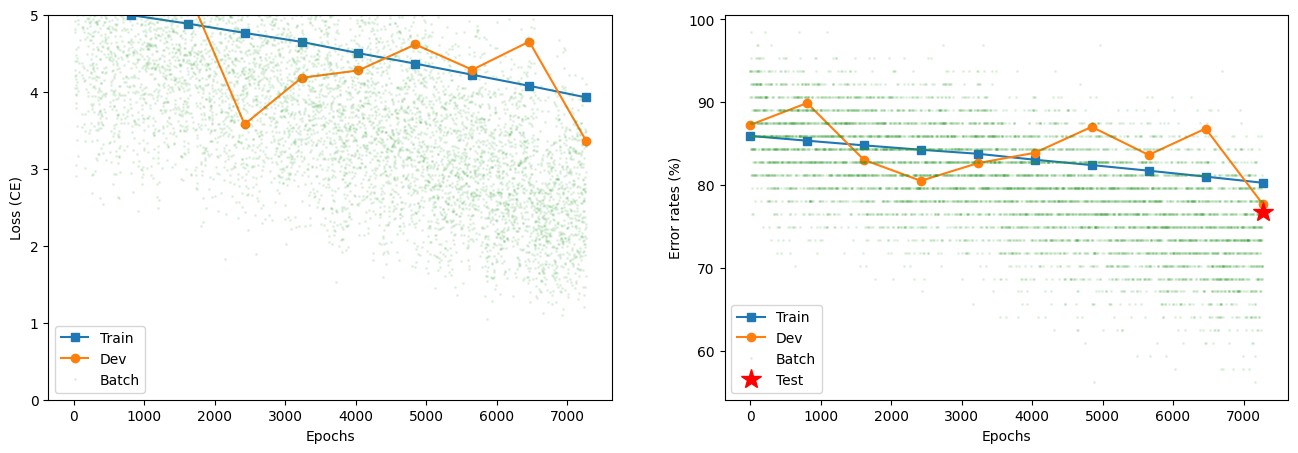

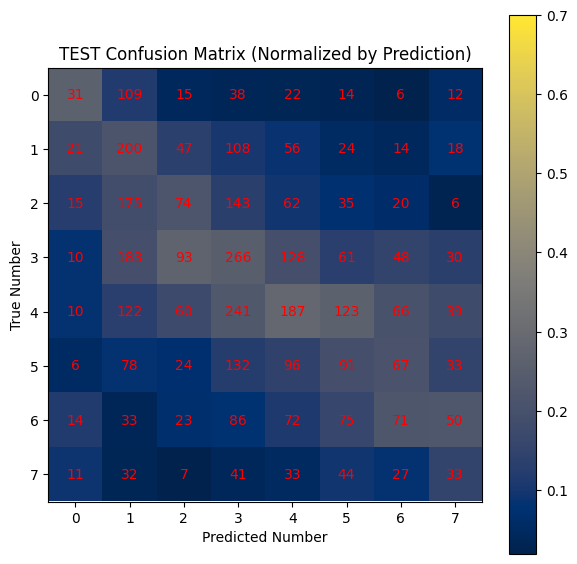

3
torch.Size([54800, 2, 120, 120])
torch.Size([54800])
Counter({4: 11207, 3: 11015, 2: 7187, 5: 7060, 1: 6485, 6: 5474, 0: 3299, 7: 3073})
Labels and respective relative ratios:
0 : 0.06 | 1 : 0.118 | 2 : 0.131 | 3 : 0.201 | 4 : 0.205 | 5 : 0.129 | 6 : 0.1 | 7 : 0.056
Class Weights:
[16.61, 8.45, 7.62, 4.98, 4.89, 7.76, 10.01, 17.83]
8 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 86.09%
Epoch 2/10
Epoch 3/10
Saving model at epoch 3 with lowest dev error: 84.83%
Epoch 4/10
Saving model at epoch 4 with lowest dev error: 77.26%
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Test Error : 77.26%


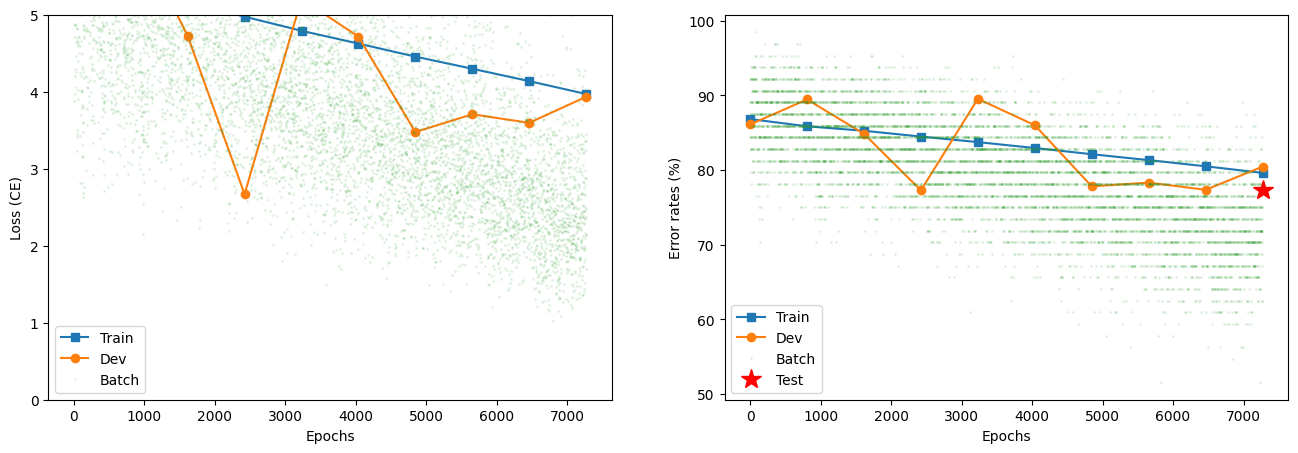

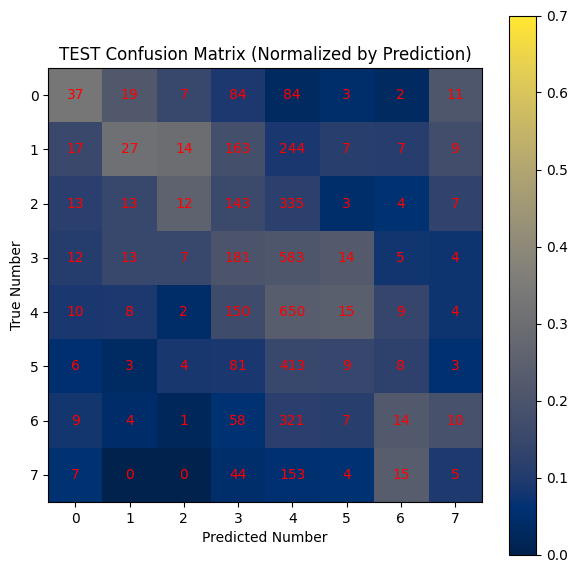

4
torch.Size([54799, 2, 120, 120])
torch.Size([54799])
Counter({4: 11073, 3: 10821, 2: 7229, 5: 7075, 1: 6522, 6: 5672, 0: 3350, 7: 3057})
Labels and respective relative ratios:
0 : 0.061 | 1 : 0.119 | 2 : 0.132 | 3 : 0.197 | 4 : 0.202 | 5 : 0.129 | 6 : 0.104 | 7 : 0.056
Class Weights:
[16.36, 8.4, 7.58, 5.06, 4.95, 7.75, 9.66, 17.93]
8 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 91.90%
Epoch 2/10
Saving model at epoch 2 with lowest dev error: 86.09%
Epoch 3/10
Epoch 4/10
Saving model at epoch 4 with lowest dev error: 81.89%
Epoch 5/10
Saving model at epoch 5 with lowest dev error: 80.25%
Epoch 6/10
Epoch 7/10
Epoch 8/10
Saving model at epoch 8 with lowest dev error: 77.01%
Epoch 9/10
Epoch 10/10
Test Error : 77.74%


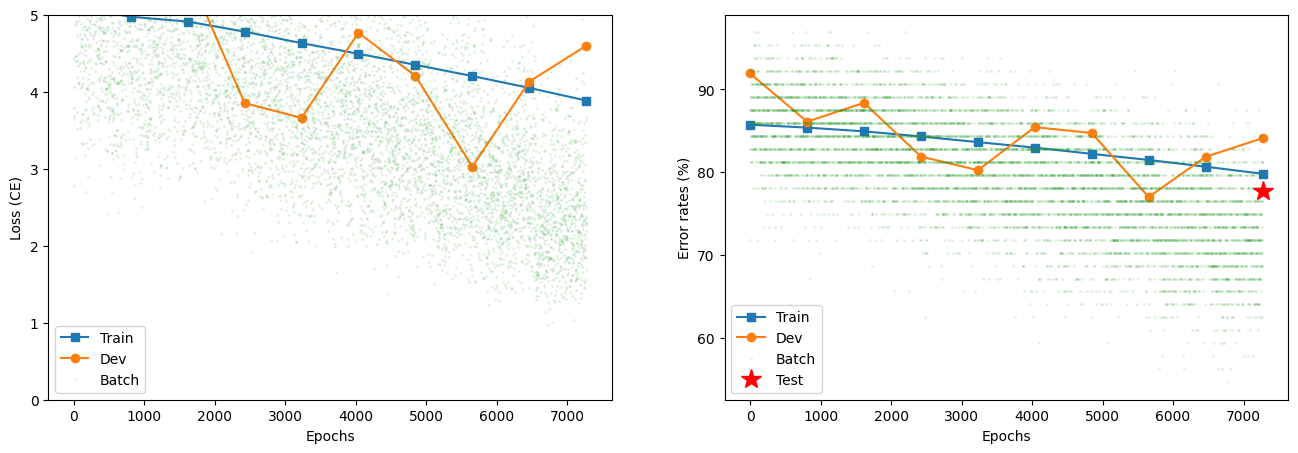

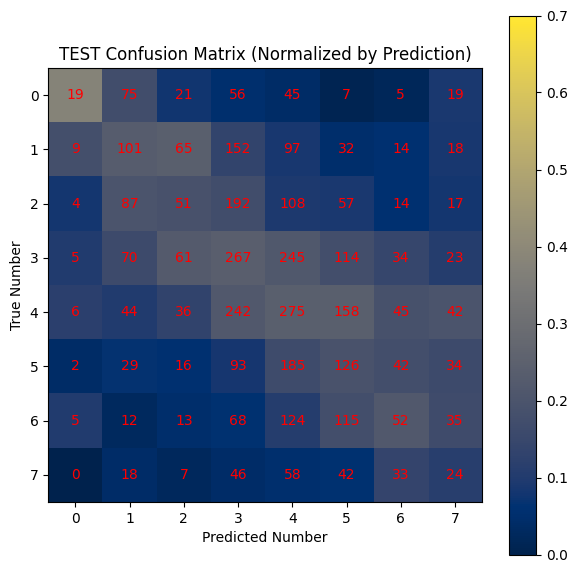

5
torch.Size([54799, 2, 120, 120])
torch.Size([54799])
Counter({4: 11118, 3: 10835, 2: 7223, 5: 7145, 1: 6522, 6: 5550, 0: 3341, 7: 3065})
Labels and respective relative ratios:
0 : 0.061 | 1 : 0.119 | 2 : 0.132 | 3 : 0.198 | 4 : 0.203 | 5 : 0.13 | 6 : 0.101 | 7 : 0.056
Class Weights:
[16.4, 8.4, 7.59, 5.06, 4.93, 7.67, 9.87, 17.88]
8 labels
Epoch 1/10
Saving model at epoch 1 with lowest dev error: 90.55%
Epoch 2/10
Saving model at epoch 2 with lowest dev error: 83.75%
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Saving model at epoch 6 with lowest dev error: 77.87%
Epoch 7/10
Saving model at epoch 7 with lowest dev error: 76.13%
Epoch 8/10
Epoch 9/10
Epoch 10/10
Test Error : 75.60%


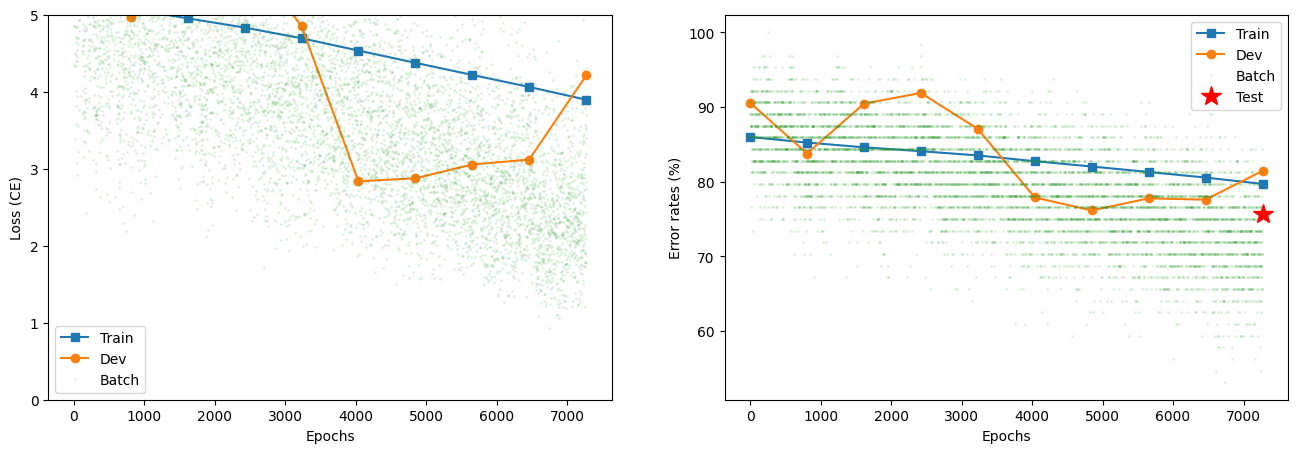

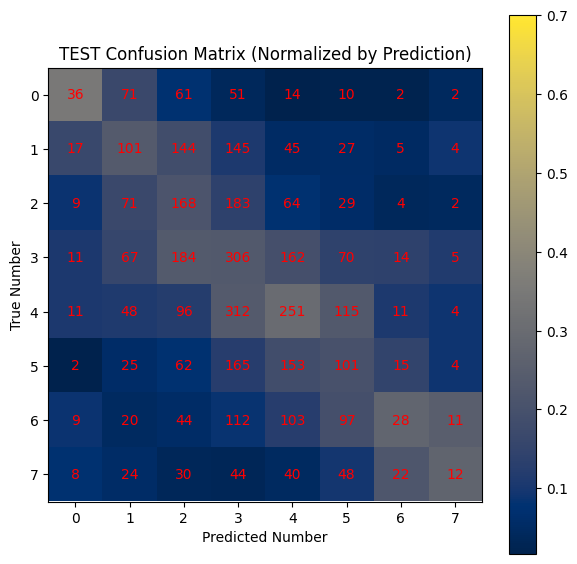

In [17]:
nEnsemble=6
nEpochs = 10
check = True
plotLabels = True
results = {}
for i in range(nEnsemble):
  print(i)
  images,targets = loadData(i,loadPath)
  labels,classWeights = labels8CE(targets,plotLabels)
  if check:
    train_loader,val_loader,test_loader = splitAndLoadData(images,labels, trainSplit = 0.15, testSplit=0.5)
    plotLabels = False
  else:
    train_loader,val_loader,_ = splitAndLoadData(images,labels, trainSplit = 0.15, testSplit=0.001)
  del images,targets
  if errorWeightMatrix != None:
    CEnet,trainLoss, valLoss, trainErr, valErr, batchLoss, batchErr,lossfun = trainCEModelWeightedError(nEpochs,train_loader,val_loader,classWeights,errorWeightMatrix)
  else:
    CEnet,trainLoss, valLoss, trainErr, valErr, batchLoss, batchErr,lossfun = trainCEModel(nEpochs,train_loader,val_loader,classWeights)
  del train_loader,val_loader
  if check:
    predictions = np.zeros((nEnsemble,test_loader.dataset.tensors[0].shape[0]))
    confusions = np.zeros((nEnsemble,len(labels.unique()),len(labels.unique())))
    check=False
  testErr ,yHat, y = calcError(CEnet,lossfun,test_loader)
  print(f'Test Error : {testErr:.2f}%')
  predictions[i,:] = torch.argmax(yHat.cpu(),axis=1).detach().numpy()
  plotTraining(trainLoss,valLoss,trainErr,valErr,batchLoss,batchErr,nEpochs)
  confusions[i,:,:] = plotConfusion(yHat,y,classWeights)
  results[i] = {'yHat':yHat.cpu(),
                'testErr':testErr,
                'trainLoss':trainLoss.cpu(),
                'valLoss':valLoss.cpu(),
                'trainErr':trainErr.cpu(),
                'valErr':valErr.cpu(),
                'batchLoss':batchLoss,
                'batchErr':batchErr,
                'confusion':confusions[i,:,:]}

results['testLabels'] = y
results['testPredictions'] = predictions
savePath = '/content/drive/MyDrive/myStocksSept2024/savedModels/'
pickle.dump(results, open(savePath+'allResults_6ensemble_10epochs_higherLr_weightedError_181024', 'wb'))



In [ ]:
pickle.dump(results, open(savePath+'allResults_6ensemble_10epochs_higherLr_171024', 'wb'))
resultsLoad = pickle.load(open(savePath+'allResults_6ensemble_10epochs_higherLr_171024', 'rb'))



In [ ]:
resultsLoad['testPredictions']

array([[0., 0., 5., ..., 6., 0., 5.],
       [0., 0., 4., ..., 0., 0., 0.]])

In [ ]:
yHatSum = torch.zeros_like(results[0]['yHat'].cpu())
for i in range(6):
  yHatSum += results[i]['yHat'].cpu()
yHatSum = yHatSum/6
testErr ,yHat, y = calcError(CEnet,lossfun,test_loader)
print(f'Test Error : {testErr:.2f}%')
plotConfusion(yHatSum,y,classWeights)

Test Error : 68.84%


In [ ]:
def majority_vote(arr):
    # Cast the array to integers if they are floats
    arr_int = arr.astype(int)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=arr_int)

majority_vote_result = majority_vote(predictions)


In [ ]:
majority_vote_result

array([1, 2, 3, ..., 0, 3, 2])

In [ ]:
100 * np.mean(majority_vote_result != y.cpu().detach().numpy())

69.93432254925808

In [ ]:
numepochs = 10
trainLoss,devLoss,trainErr,devErr,CEnet,CElossfun,batchLoss,batchErr = trainCEModel(numepochs)

In [ ]:
run 6 labels
load data
divide to train,dev,test
save test
do five epochs each iteration
create a cnet for every batch of data (~6 times)
  train
  plot progresssion, confusion for dev and test (and save the values)
  run test and save results in matrix
  delete train and dev sets
  load new one
how many of each prediction did all models agree on?
hoy many from the ones they agreed on were correct?
  compared to the ones they did not agree on?
    5/6 agreed , 4/6 agreed, 3/6 agreed, 2/6 agreed, 1/6 agreed

Repeat 1/5
0
torch.Size([54804, 2, 120, 120])
torch.Size([54804])
Counter({4: 11304, 3: 10920, 2: 7070, 5: 7024, 1: 6501, 6: 5654, 0: 3293, 7: 3038})
Labels and respective relative ratios:
0 : 0.06 | 1 : 0.119 | 2 : 0.129 | 3 : 0.199 | 4 : 0.206 | 5 : 0.128 | 6 : 0.103 | 7 : 0.055
Class Weights:
[16.64, 8.43, 7.75, 5.02, 4.85, 7.8, 9.69, 18.04]


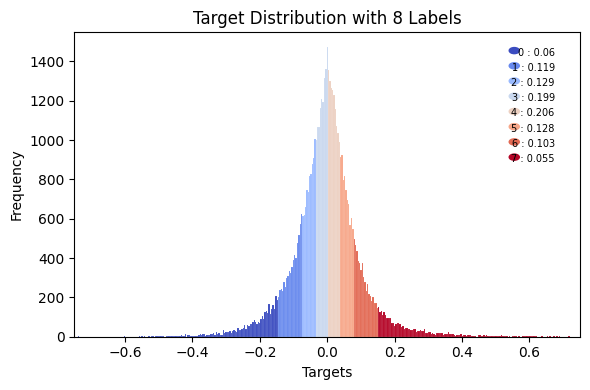

8 labels
Epoch 1/2
Saving model at epoch 1 with lowest dev error: 90.24%
Epoch 2/2
Saving model at epoch 2 with lowest dev error: 86.93%
Test Error : 86.99%


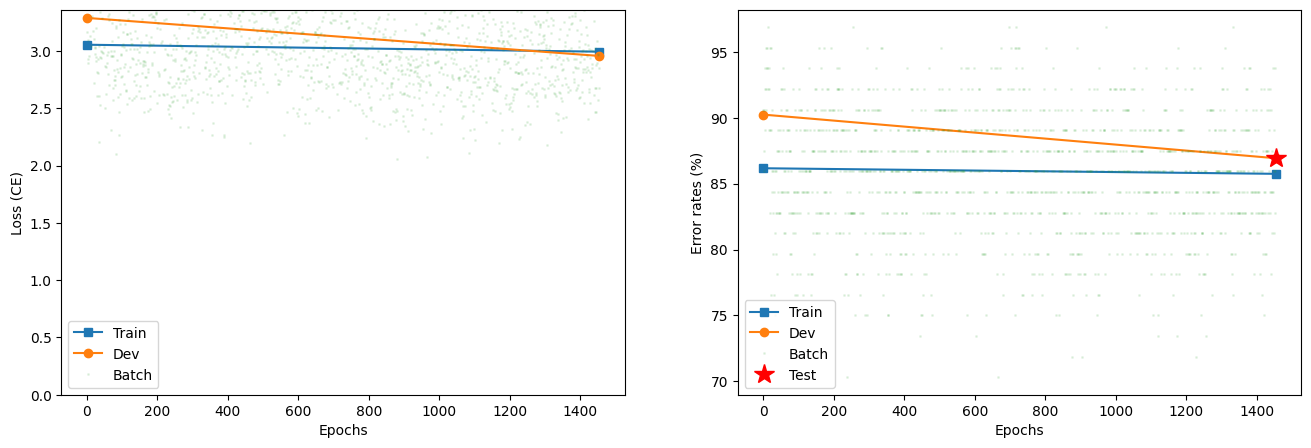

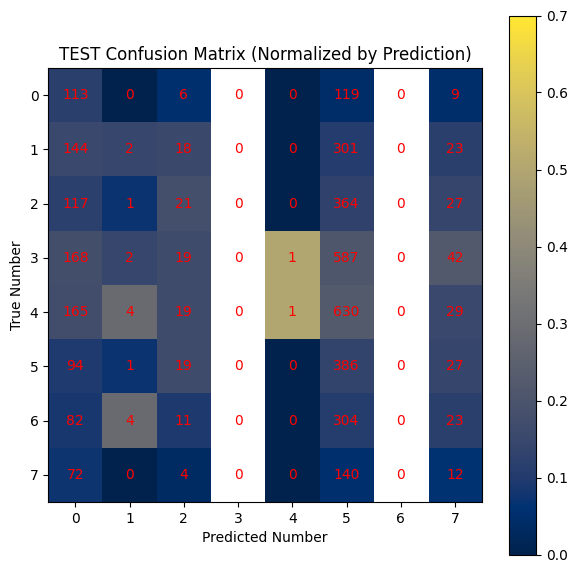

1
torch.Size([54804, 2, 120, 120])
torch.Size([54804])
Counter({4: 11289, 3: 11002, 2: 7217, 5: 6927, 1: 6473, 6: 5599, 0: 3284, 7: 3013})
Labels and respective relative ratios:
0 : 0.06 | 1 : 0.118 | 2 : 0.132 | 3 : 0.201 | 4 : 0.206 | 5 : 0.126 | 6 : 0.102 | 7 : 0.055
Class Weights:
[16.69, 8.47, 7.59, 4.98, 4.85, 7.91, 9.79, 18.19]
8 labels
Epoch 1/2


AssertionError: No inf checks were recorded for this optimizer.

In [30]:
from typing import Optional
nEnsemble=6
nEpochs = 2
nRepeatAllData = 5
check = True
plotLabels = True
CEnet = None
lossfun = None
optimizer  = None
results = {}
for j in range(nRepeatAllData):
  print(f'Repeat {j+1}/{nRepeatAllData}')
  results[j]= {}
  for i in range(nEnsemble):
    print(i)
    images,targets = loadData(i,loadPath)
    labels,classWeights = labels8CE(targets,plotLabels)
    if check:
      train_loader,val_loader,test_loader = splitAndLoadData(images,labels, trainSplit = 0.15, testSplit=0.5)
      plotLabels = False
    else:
      train_loader,val_loader,_ = splitAndLoadData(images,labels, trainSplit = 0.15, testSplit=0.001)
    del images,targets
    if errorWeightMatrix != None:
      CEnet,trainLoss, valLoss, trainErr, valErr, batchLoss, batchErr,lossfun, optimizer = trainCEModelWeightedError(nEpochs,train_loader,val_loader,classWeights,errorWeightMatrix,CEnet,lossfun, optimizer)
    else:
      CEnet,trainLoss, valLoss, trainErr, valErr, batchLoss, batchErr,lossfun,optimizer = trainCEModel(nEpochs,train_loader,val_loader,classWeights,CEnet,lossfun, optimizer)
    del train_loader,val_loader
    if check:
      predictions = np.zeros((nEnsemble,test_loader.dataset.tensors[0].shape[0]))
      confusions = np.zeros((nEnsemble,len(labels.unique()),len(labels.unique())))
      check=False
    testErr ,yHat, y = calcError(CEnet,lossfun,test_loader)
    print(f'Test Error : {testErr:.2f}%')
    predictions[i,:] = torch.argmax(yHat.cpu(),axis=1).detach().numpy()
    plotTraining(trainLoss,valLoss,trainErr,valErr,batchLoss,batchErr,nEpochs)
    confusions[i,:,:] = plotConfusion(yHat,y,classWeights)
    results[j][i] = {'yHat':yHat.cpu(),
                  'testErr':testErr,
                  'trainLoss':trainLoss.cpu(),
                  'valLoss':valLoss.cpu(),
                  'trainErr':trainErr.cpu(),
                  'valErr':valErr.cpu(),
                  'batchLoss':batchLoss,
                  'batchErr':batchErr,
                  'confusion':confusions[i,:,:]}

  results[j]['testLabels'] = y
  results[j]['testPredictions'] = predictions
savePath = '/content/drive/MyDrive/myStocksSept2024/savedModels/'
pickle.dump(results, open(savePath+'allResults_6ensemble_10epochs_higherLr_weightedError_sameCEnet_181024', 'wb'))